In [2]:
#调用pandas matplotlib seaborn库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# 设置绘图风格
sns.set_theme(style="white", palette="Set2")
# 设置中文字体，防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
df = pd.read_csv(r"C:\Users\CUYJTDYJ\Desktop\新建文件夹\covid.train.csv") #读取训练集

In [3]:
y = df["tested_positive.2"]
X = df.drop(columns = ["id","tested_positive.2"])

In [4]:
#拆分训练集与验证集
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=2025 #用于固定随机种子的42是终极答案，不过我才刚开始，不奢求这个
)

In [5]:
#特征标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()    # 一个计算均值与方差的黑箱
scaler.fit(X_train)          # 只用训练集计算均值和方差

X_train_scaled = scaler.transform(X_train)  #根据训练集的分布将训练集和验证集数据转化为均值为0，标准差为1的分布
X_val_scaled = scaler.transform(X_val)


sklearn库的自动计算

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()            # 线性回归 
model.fit(X_train_scaled, y_train)    # 学习权重和偏置
y_pred = model.predict(X_val_scaled)  # y的预测值

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = mean_squared_error(y_val, y_pred)  #均方误差函数
print("验证集 RMSE:", rmse) 

验证集 RMSE: 0.9602553076575705


In [6]:
weight = model.coef_   #获取权重
for name, weight in zip(X.columns, weight):
    print(f"{name:25s} {weight:.4f}")

AL                        0.1233
AK                        -0.2205
AZ                        -0.1033
AR                        0.0699
CA                        -0.1091
CO                        -0.1017
CT                        -0.0750
FL                        -0.0276
GA                        0.0235
ID                        0.2218
IL                        0.0156
IN                        0.0598
IA                        0.1132
KS                        0.1112
KY                        -0.0633
LA                        0.1746
MD                        -0.1389
MA                        -0.1358
MI                        -0.0860
MN                        -0.0704
MS                        0.1934
MO                        0.0724
NE                        0.0679
NV                        0.1303
NJ                        -0.0206
NM                        -0.0749
NY                        -0.1133
NC                        -0.0048
OH                        0.0711
OK                        0.

SGD以及梯度下降

In [41]:
#尝试不用scikit-learn，进行梯度下降  #下的操作为使用numpy数组，以作对比
#import numpy as np
import torch
loss_history = []   # 新增：用来存每一轮的 loss
# 准备数据（numpy）
# x = X_train_scaled  # shape (N, D)
# y = y_train.values.reshape(-1, 1)  # shape (N, 1)
x = torch.tensor(X_train_scaled,dtype = torch.float32)  #输入x为二维数组
y = torch.tensor(y_train.values,dtype = torch.float32).reshape(-1,1)
N, D = x.shape

# 初始化参数
# w = np.zeros((D, 1))
# b = 0.0
w = torch.zeros((D,1),requires_grad = True)   #自动求导
b = torch.zeros(1,requires_grad = True)
# 超参数
lr = 0.044        # 学习率 0.45就发散了！！！
epochs = 1200

for epoch in range(epochs):

    # 前向计算
    y_pred = x @ w + b     # 预测值 (N,1)

    # 计算损失 (MSE)
    loss = torch.mean((y_pred - y)**2)    #此处为均方误差

    # 计算梯度
    # dw = (2/N) * x.T @ (y_pred - y)   
    # db = (2/N) * np.sum(y_pred - y)
    loss.backward()    #auto-grad
    # 梯度下降更新
    # w -= dw * lr
    # b -= db * lr
    with torch.no_grad():     #禁用梯度计算，参数的更新是物理操作，不会计入梯度计算
        w.data -= lr * w.grad
        b.data -= lr * b.grad
    w.grad.zero_()  #
    b.grad.zero_()
    loss_history.append(loss.item())
    # 每100次打印一下
    if epoch % 100 == 0:
        print(f"epoch {epoch}, loss = {loss:.4f}")

epoch 0, loss = 331.5569
epoch 100, loss = 1.3904
epoch 200, loss = 1.0710
epoch 300, loss = 0.9998
epoch 400, loss = 0.9647
epoch 500, loss = 0.9410
epoch 600, loss = 0.9226
epoch 700, loss = 0.9073
epoch 800, loss = 0.8942
epoch 900, loss = 0.8830
epoch 1000, loss = 0.8734
epoch 1100, loss = 0.8650


显示系数

绘制损失图像

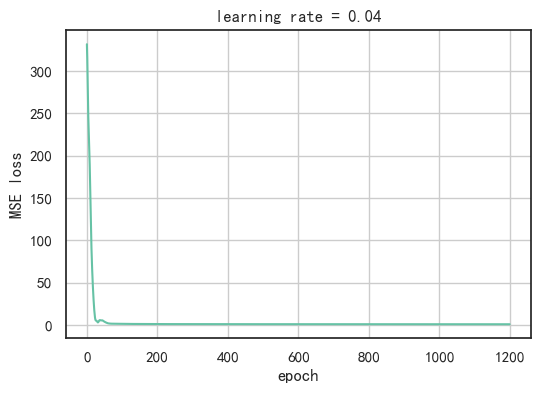

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title(f"learning rate = {lr}")
plt.grid(True)
plt.show()


学习率扫描图

training with lr = 0.001
training with lr = 0.005
training with lr = 0.01
training with lr = 0.02
training with lr = 0.03
training with lr = 0.04
training with lr = 0.044
training with lr = 0.045


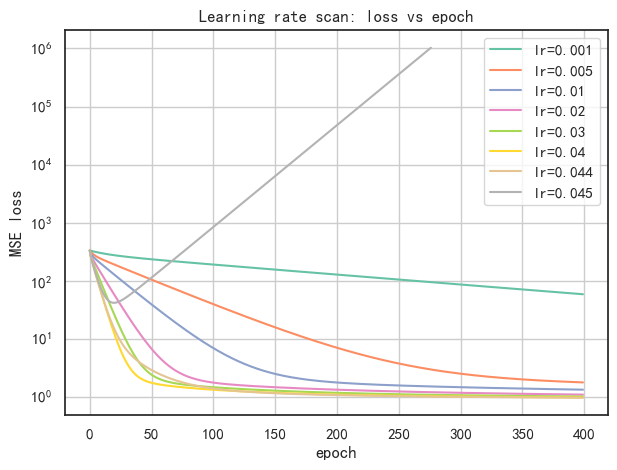

In [34]:
import torch
import numpy as np

def train_and_record(lr, epochs=400):
    # 保证每个学习率用同样的初始化，方便对比
    torch.manual_seed(0)

    X_np = X_train_scaled.astype("float32")
    y_np = y_train.values.reshape(-1, 1).astype("float32")

    X_t = torch.from_numpy(X_np)
    y_t = torch.from_numpy(y_np)

    N, D = X_t.shape

    w = torch.zeros((D, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    loss_history = []

    for epoch in range(epochs):
        # 前向
        y_pred = X_t @ w + b
        loss = torch.mean((y_pred - y_t) ** 2)

        # 反向
        loss.backward()

        # 参数更新
        with torch.no_grad():
            w.data -= lr * w.grad
            b.data -= lr * b.grad
        w.grad.zero_()
        b.grad.zero_()

        # 记录 loss
        loss_history.append(loss.item())

        # 如果已经明显爆炸了，就提前停（防止数值溢出）（这个地方不太会欸）
        if not np.isfinite(loss_history[-1]) or loss_history[-1] > 1e6:
            # 用 NaN 填满剩下的 epoch，方便画图对齐
            loss_history += [np.nan] * (epochs - len(loss_history))
            break

    return loss_history
lrs = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.044, 0.045]

all_histories = {}

for lr in lrs:
    print(f"training with lr = {lr}")
    losses = train_and_record(lr, epochs=400)
    all_histories[lr] = losses    #dictionary的每一个key对应的value的style是list

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

for lr, losses in all_histories.items():
    plt.plot(losses, label=f"lr={lr}")

plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.yscale("log")          # 用对数轴，能同时看到大/小 loss
plt.title("Learning rate scan: loss vs epoch")
plt.legend()               #加网格
plt.grid(True)
plt.show()

可以看出学习率的选择过于苛刻，过小太过缓慢，过大容易出界，我们引入动量来让其减小受外界微小扰动的干扰

In [19]:
import torch
import numpy as np
 
#引入输入量
X_np = X_train_scaled.astype("float32")
y_np = y_train.values.astype("float32").reshape(-1,1)

X_t = torch.from_numpy(X_np)
y_t = torch.from_numpy(y_np)

#定义各类参数和超参数
N,D = X_t.shape
w = torch.zeros((D,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)
lr = 0.04
epochs = 200

#动量
v_w = torch.zeros_like(w)
v_b = torch.zeros_like(b)
beta = 0.9  #动量衰减

loss_history = []

for epoch in range(epochs):
    #前向：
    #预测值
    y_pred = X_t @ w + b
    #损失函数
    loss = torch.mean((y_pred - y_t)**2)
    
    #后向：
    #反向传播，自动求导
    loss.backward()
    
    #动量更新
    with torch.no_grad():
        v_w = beta * v_w + (1 - beta) * w.grad
        v_b = beta * v_b + (1 - beta) * b.grad
    
        w.data -= lr * v_w
        b.data -= lr * v_b
    
    #梯度清零
    w.grad.zero_()
    b.grad.zero_()

    loss_history.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"epoch {epoch},loss = {loss.item():.4f}" )

epoch 0,loss = 331.5569
epoch 100,loss = 1.3452


In [51]:
w_flat = w.reshape(-1)
for name,weight in zip(X.columns,w_flat):
    print(f"{name:25s}{weight:.4f}")

AL                       0.0915
AK                       -0.1764
AZ                       -0.0925
AR                       0.0689
CA                       -0.0901
CO                       -0.0727
CT                       -0.0859
FL                       -0.0118
GA                       0.0118
ID                       0.2139
IL                       0.0123
IN                       0.0467
IA                       0.1166
KS                       0.1164
KY                       -0.0775
LA                       0.1703
MD                       -0.1734
MA                       -0.1474
MI                       -0.0676
MN                       -0.0697
MS                       0.1838
MO                       0.0666
NE                       0.0594
NV                       0.1279
NJ                       -0.0225
NM                       -0.0642
NY                       -0.0889
NC                       0.0026
OH                       0.0787
OK                       0.1114
OR                       -

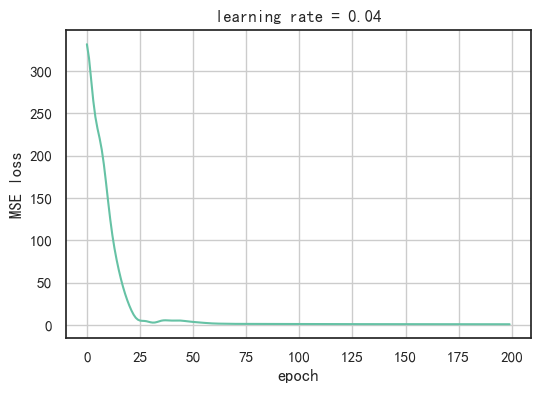

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title(f"learning rate = {lr}")
plt.grid(True)
plt.show()

好吧，考虑使用Adam优化器

In [82]:
import torch

#设置输入
X_t = torch.tensor(X_train_scaled,dtype=torch.float32)
y_t = torch.tensor(y_train.values,dtype=torch.float32).reshape(-1,1)

X_np = X_val_scaled.astype("float32")
y_np = y_val.values.astype("float32")

X_v = torch.from_numpy(X_np)
y_v = torch.from_numpy(y_np)

#设置超参数与参数
N,D = X_t.shape
lr = 0.05
epochs = 600

w = torch.zeros((D,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)

#设置优化器
optimizer = torch.optim.Adam([w,b],lr = lr)

loss_history = []
loss_history_val = [] 

for epoch in range(epochs):
    y_pred = X_t @ w + b 
    loss = torch.mean((y_pred - y_t)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    y_v_pred = X_v @ w + b
    loss_v = torch.mean((y_v_pred - y_v)**2)
    loss_history_val.append(loss_v.item())
    if epoch % 50 == 0:
        print(f"epoch {epoch}, loss={loss.item():.6f},loss_v={loss_v.item():.6f}")

epoch 0, loss=331.556915,loss_v=319.677917
epoch 50, loss=200.939270,loss_v=304.217224
epoch 100, loss=141.514786,loss_v=249.453217
epoch 150, loss=96.851883,loss_v=205.621475
epoch 200, loss=64.281082,loss_v=173.483994
epoch 250, loss=41.332684,loss_v=150.826340
epoch 300, loss=25.758005,loss_v=135.445297
epoch 350, loss=15.603602,loss_v=125.414459
epoch 400, loss=9.257989,loss_v=119.143921
epoch 450, loss=5.463517,loss_v=115.392632
epoch 500, loss=3.294294,loss_v=113.246887
epoch 550, loss=2.108605,loss_v=112.073486


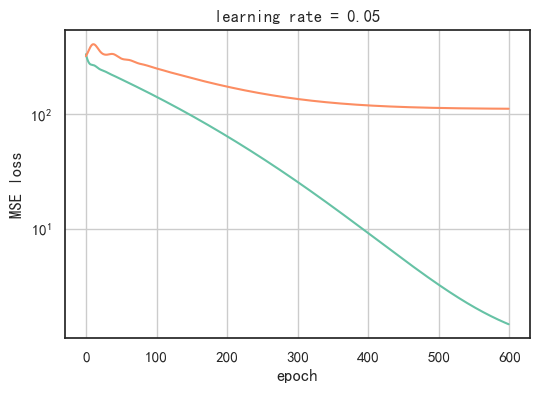

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.plot(loss_history_val)
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.yscale("log")
plt.title(f"learning rate = {lr}")
plt.grid(True)
plt.show()

显然，模型欠拟合了，我们开始试着引入ReLU

In [33]:
import torch
import torch.nn as nn
class MLP (nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.net = nn.Sequential(  #把几层网络组合
        nn.Linear(input_dim,64),
        nn.ReLU(),
        nn.Linear(64,1), 
        )
    def forward(self,x):
        return self.net(x)

In [34]:
X_np_t = X_train_scaled.astype("float32")
y_np_t = y_train.values.astype("float32")
X_np_v = X_val_scaled.astype("float32")
y_np_v = y_val.values.astype("float32")

X_t = torch.from_numpy(X_np_t)
y_t = torch.from_numpy(y_np_t)
X_v = torch.from_numpy(X_np_v)
y_v = torch.from_numpy(y_np_v)

#初始化模型和优化器
N,D = X_t.shape
model = MLP(D)
optimizer = torch.optim.Adam(model.parameters(),lr=0.2)
criterion = nn.MSELoss()

#训练循环
epochs = 200
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train()
    y_pred_t = model(X_t)
    loss_t = criterion(y_pred_t,y_t)
    
    optimizer.zero_grad()
    loss_t.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_v = model(X_v)
        loss_v = criterion(y_pred_v,y_v)
        
    train_loss_history.append(loss_t.item())
    val_loss_history.append(loss_v.item())
    
    if epoch%50 == 0:
        print(f"epoch:{epoch},loss_train:{loss_t.item():.4f},loss_val:{loss_v.item():.4f}")
        

epoch:0,loss_train:323.4786,loss_val:622.4479
epoch:50,loss_train:60.7320,loss_val:57.8284
epoch:100,loss_train:58.9274,loss_val:56.3835
epoch:150,loss_train:58.7277,loss_val:56.1428


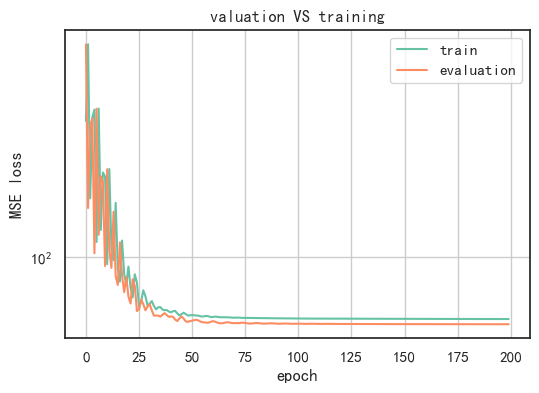

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.plot(train_loss_history ,label="train")
plt.plot(val_loss_history,label="evaluation")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("valuation VS training")
plt.grid(True)
plt.legend()
plt.show()

为了避免过拟合（当然本例中远未达到），我们试着引入early-stopping

In [39]:
best_val_loss = float("inf")
patience = 20
patience_counter = 0

#同样的训练方式
train_loss_history = []
val_loss_history  = []

for epoch in range(epochs):
    model.train()
    y_pred_t = model(X_t)
    loss_t = criterion(y_pred_t,y_t)
    
    optimizer.zero_grad()
    loss_t.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_v = model(X_v)
        loss_v = criterion(y_pred_v,y_v)
    
    train_loss_history.append(loss_t.item())
    val_loss_history.append(loss_v.item())
        
    #Early-Stopping check
    if loss_v < best_val_loss:
        best_val_loss = loss_v
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        
    if epoch%50 == 0:
        print(f"epoch:{epoch},loss_train:{loss_t.item():.4f},loss_val:{loss_v.item():.4f}")
    if patience_counter >= patience:
        print("Early Stopping!")
        break
model.load_state_dict(best_model_state)

epoch:0,loss_train:58.8618,loss_val:56.2459
epoch:50,loss_train:58.7532,loss_val:56.1772
epoch:100,loss_train:58.7004,loss_val:56.2085
Early Stopping!


<All keys matched successfully>

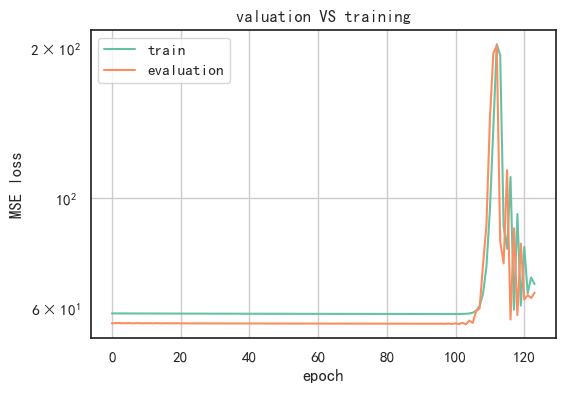

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.plot(train_loss_history ,label="train")
plt.plot(val_loss_history,label="evaluation")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("valuation VS training")
plt.grid(True)
plt.legend()
plt.show()

加入weight decay（正则化），通过惩罚大的权重逼迫函数学习更简单的曲线，从而缓解过拟合

In [41]:
best_val_loss = float("inf")
patience = 20
patience_counter = 0
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.2,
    weight_decay = 1e-4)
#同样的训练方式
train_loss_history = []
val_loss_history  = []

for epoch in range(epochs):
    model.train()
    y_pred_t = model(X_t)
    loss_t = criterion(y_pred_t,y_t)
    
    optimizer.zero_grad()
    loss_t.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_v = model(X_v)
        loss_v = criterion(y_pred_v,y_v)
    
    train_loss_history.append(loss_t.item())
    val_loss_history.append(loss_v.item())
        
    #Early-Stopping check
    if loss_v < best_val_loss:
        best_val_loss = loss_v
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        
    if epoch%50 == 0:
        print(f"epoch:{epoch},loss_train:{loss_t.item():.4f},loss_val:{loss_v.item():.4f}")
    if patience_counter >= patience:
        print("Early Stopping!")
        break
model.load_state_dict(best_model_state)

epoch:0,loss_train:66.3462,loss_val:1131.7557
epoch:50,loss_train:64.7305,loss_val:65.5667
Early Stopping!


<All keys matched successfully>

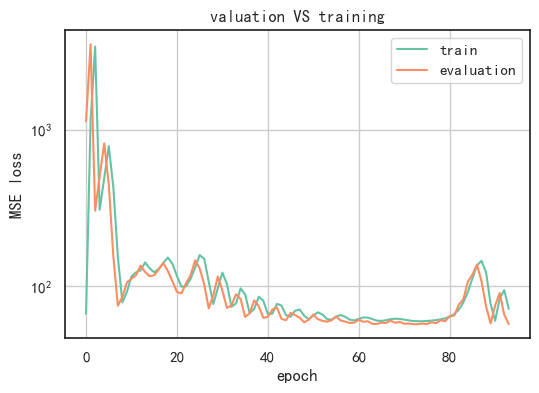

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.plot(train_loss_history ,label="train")
plt.plot(val_loss_history,label="evaluation")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("valuation VS training")
plt.grid(True)
plt.legend()
plt.show()

当然，我们也可以用Dropout（在每一个batch内随机关闭一些神经元，让函数在信息不完整的情况下尽可能的表现，减少因对个别神经元过分依赖导致的过拟合现象的发生）

In [91]:
class MLP(nn.Module):
    def __init__(self, input_dim,dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
#             nn.Dropout(dropout),     
#             nn.Linear(128, 64),
#             nn.ReLU(),
            nn.Linear(64,1)
        )

    def forward(self, x):
        return self.net(x)


In [95]:
best_val_loss = float("inf")
patience = 20
patience_counter = 0
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
#     weight_decay = 1e-4
)
#同样的训练方式
train_loss_history = []
val_loss_history  = []

for epoch in range(epochs):
    model.train()
    y_pred_t = model(X_t)
    loss_t = criterion(y_pred_t,y_t)
    
    optimizer.zero_grad()
    loss_t.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_v = model(X_v)
        loss_v = criterion(y_pred_v,y_v)
    
    train_loss_history.append(loss_t.item())
    val_loss_history.append(loss_v.item())
        
    #Early-Stopping check
    if loss_v < best_val_loss:
        best_val_loss = loss_v
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        
#     if epoch%50 == 0:
    print(f"epoch:{epoch},loss_train:{loss_t.item():.4f},loss_val:{loss_v.item():.4f}")
    if patience_counter >= patience:
        print("Early Stopping!")
        break
model.load_state_dict(best_model_state)

epoch:0,loss_train:0.5443,loss_val:254.7373
epoch:1,loss_train:77.5332,loss_val:111.5247
epoch:2,loss_train:1.6945,loss_val:114.5716
epoch:3,loss_train:50.4442,loss_val:110.4949
epoch:4,loss_train:46.8923,loss_val:97.7580
epoch:5,loss_train:11.5027,loss_val:121.0347
epoch:6,loss_train:3.8040,loss_val:164.5813
epoch:7,loss_train:23.1803,loss_val:178.1404
epoch:8,loss_train:29.8360,loss_val:155.0229
epoch:9,loss_train:15.5411,loss_val:124.0966
epoch:10,loss_train:2.1833,loss_val:108.0688
epoch:11,loss_train:4.7045,loss_val:105.9279
epoch:12,loss_train:15.1739,loss_val:105.0086
epoch:13,loss_train:17.3638,loss_val:102.6542
epoch:14,loss_train:9.1811,loss_val:106.5161
epoch:15,loss_train:1.3972,loss_val:120.3089
epoch:16,loss_train:2.2620,loss_val:135.6901
epoch:17,loss_train:8.3764,loss_val:140.2059
epoch:18,loss_train:10.6202,loss_val:131.1481
epoch:19,loss_train:6.4340,loss_val:116.8232
epoch:20,loss_train:1.5210,loss_val:106.6543
epoch:21,loss_train:1.3888,loss_val:103.1832
epoch:22,lo

<All keys matched successfully>

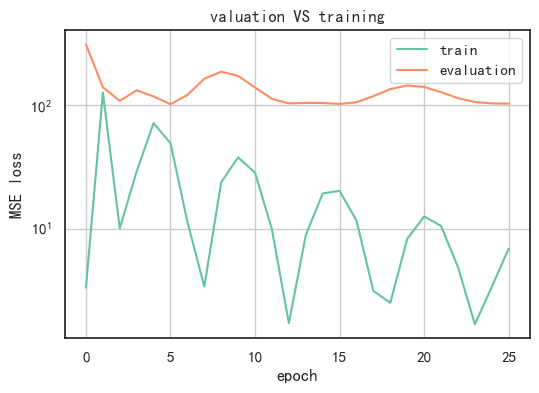

In [93]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.plot(train_loss_history ,label="train")
plt.plot(val_loss_history,label="evaluation")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("valuation VS training")
plt.grid(True)
plt.legend()
plt.show()

我们试着计算模型在验证集上的平均误差，发现效果比线性略好

In [97]:
import numpy as np

y_mean = y_train.mean()
baseline_mse = np.mean((y_val.values - y_mean)**2)
baseline_rmse = baseline_mse ** 0.5
print(baseline_mse, baseline_rmse)


55.94302137681789 7.479506760262864


那我们来试一试测试集吧，看看最终的效果吧

In [101]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
#读取文件，确认输入
df = pd.read_csv(r"C:\Users\CUYJTDYJ\Desktop\新建文件夹\covid.train.csv")
y = df["tested_positive.2"]
X = df.drop(columns = ["id","tested_positive.2"])
#特征化处理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_np = X_scaled.astype("float32")
y_np = y.values.astype("float32")

X_t = torch.from_numpy(X_np)
y_t = torch.from_numpy(y_np).reshape(-1,1)

D = X_t.shape[1]

#定义MLP模型
class MLP (nn.Module):
    def __init__(self,input_dim,hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,1)
        )
    def forward(self,x):
        return self.net(x)

model = MLP(D,hidden_dim=64)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
criterion = nn.MSELoss()

epochs = 60

for epoch in range(epochs):
    model.train()  #训练阶段
    y_pred = model(X_t)
    loss = criterion(y_pred,y_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"epoch:{epoch},loss:{loss.item()}")

epoch:0,loss:323.9031066894531
epoch:10,loss:74.0511703491211
epoch:20,loss:40.98497009277344
epoch:30,loss:13.894292831420898
epoch:40,loss:7.274100303649902
epoch:50,loss:5.800881862640381


In [110]:
test_df = pd.read_csv(r"C:\Users\CUYJTDYJ\Desktop\新建文件夹\covid.test.csv")


X_test = test_df.drop(columns=["id"])

X_test_scaled = scaler.transform(X_test)  # 用刚才的 scaler！
Xt_np = X_test_scaled.astype("float32")
Xt_t = torch.from_numpy(Xt_np)

In [111]:
model.eval()
with torch.no_grad():
    y_test_pred = model(Xt_t).cpu().numpy().reshape(-1)
submission = pd.DataFrame({
    "id": test_df["id"],
    "tested_positive.2": y_test_pred
})
submission.to_csv("submission.csv", index=False)